In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spilu

import jlinops

In [2]:
grid_shape = (10, 10)
R = jlinops.Dirichlet2DSym(grid_shape)
A = R.T @ R
Amat = jlinops.black_box_to_dense(A)

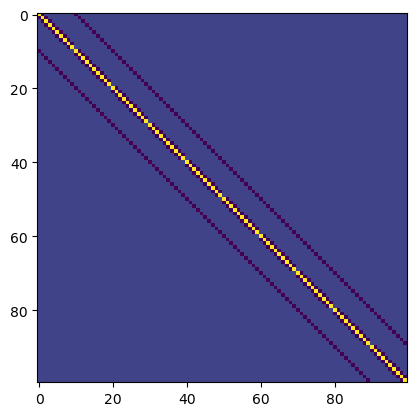

In [3]:
plt.imshow(Amat)
plt.show()

In [4]:
spilu_obj = spilu(Amat, permc_spec="NATURAL", fill_factor=1.0, drop_tol=1.0)


/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:506: SparseEfficiencyWarning: spilu converted its input to CSC format
  warn('spilu converted its input to CSC format',


In [7]:
jlinops.bandwidth(Amat)

10

In [5]:
Aest = spilu_obj.L @ spilu_obj.U

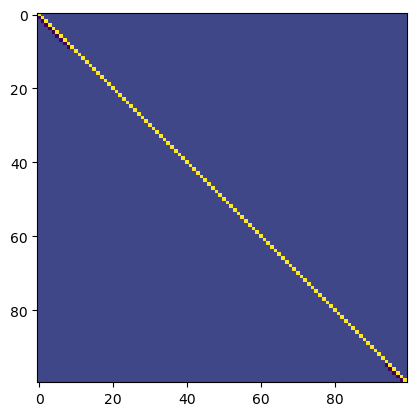

In [6]:
plt.imshow(spilu_obj.L.toarray())
plt.show()

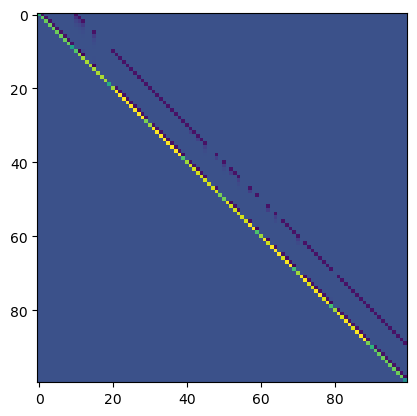

In [54]:
plt.imshow(spilu_obj.U.toarray())
plt.show()

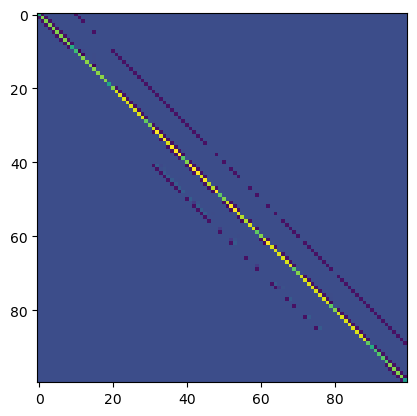

In [55]:
plt.imshow(Aest.toarray())
plt.show()

In [20]:
help(M)

Help on SuperLU object:

class SuperLU(object)
 |  LU factorization of a sparse matrix.
 |  
 |  Factorization is represented as::
 |  
 |      Pr @ A @ Pc = L @ U
 |  
 |  To construct these `SuperLU` objects, call the `splu` and `spilu`
 |  functions.
 |  
 |  Attributes
 |  ----------
 |  shape
 |  nnz
 |  perm_c
 |  perm_r
 |  L
 |  U
 |  
 |  Methods
 |  -------
 |  solve
 |  
 |  Notes
 |  -----
 |  
 |  .. versionadded:: 0.14.0
 |  
 |  Examples
 |  --------
 |  The LU decomposition can be used to solve matrix equations. Consider:
 |  
 |  >>> import numpy as np
 |  >>> from scipy.sparse import csc_matrix, linalg as sla
 |  >>> A = csc_matrix([[1,2,0,4],[1,0,0,1],[1,0,2,1],[2,2,1,0.]])
 |  
 |  This can be solved for a given right-hand side:
 |  
 |  >>> lu = sla.splu(A)
 |  >>> b = np.array([1, 2, 3, 4])
 |  >>> x = lu.solve(b)
 |  >>> A.dot(x)
 |  array([ 1.,  2.,  3.,  4.])
 |  
 |  The ``lu`` object also contains an explicit representation of the
 |  decomposition. The permu

# Make op

In [18]:
from jlinops import _CustomLinearOperator, get_device

In [ ]:
class SPILUOperator(_CustomLinearOperator):
    """Represents an incomplete LU factorization. 
    """

    def __init__(self, A, *args, **kwargs):

        self.A = A
        self.device = get_device(A)

        # Perform SPILU factorization


        device = get_device(weights)
        self.R = Dirichlet2DSym(grid_shape, device=device)
        assert self.R.shape[0] == len(weights), "Weights incompatible!"
        self.weights = weights
        self.grid_shape = grid_shape
        self.warmstart_prev = warmstart_prev
        self.check = check
        self.which = which
        self.dst_eps = dst_eps
        self.args = args
        self.kwargs = kwargs
        
       
        # Build RtR and Rw
        self.RtR = self.R.T @ self.R
        self.Dw = DiagonalOperator(weights)
        self.Rw = self.Dw @ self.R

        # Get Rpinv (with identity weights)
        self.RtRpinv = dst_pinv( self.RtR, grid_shape, eps=self.dst_eps )

        # Take care of W (columns span the kernel of R)
        if device == "cpu":
            W = np.ones((self.R.shape[1],1))
        else:
            W = cp.ones((self.R.shape[1],1))
            
        self.W = MatrixLinearOperator(W)
        self.Wpinv = QRPinvOperator(self.W)

        # Make Rwpinv
        self.Rwpinv = CGPreconditionedPinvModOperator(self.Rw, self.W, self.Wpinv, self.RtRpinv, warmstart_prev=warmstart_prev, check=check, which=which, dst_eps=self.dst_eps, *args, **kwargs)

        def _matvec(x):
            return self.Rwpinv.matvec(x)

        def _rmatvec(x):
            return self.Rwpinv.rmatvec(x)

        super().__init__( self.Rwpinv.shape, _matvec, _rmatvec, dtype=np.float64, device=device)
        

    def to_gpu(self):
        return CGWeightedDirichlet2DSymPinvOperator(self.grid_shape, cp.asarray(self.weights), warmstart_prev=self.warmstart_prev, check=self.check, which=self.which, *self.args, **self.kwargs)
    

    def to_cpu(self):
        return CGWeightedDirichlet2DSymPinvOperator(self.grid_shape, cp.numpy(self.weights), warmstart_prev=self.warmstart_prev, check=self.check, which=self.which, *self.args, **self.kwargs)
    